## A note book to review and summarize QC metrics for HRApop v1.0

## Install and import libraries

In [13]:
%pip install requests pandas seaborn duckdb matplotlib

import os
import zipfile
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## Load data

In [14]:
import os
import zipfile


def unzip_if_needed(zip_path: str, extract_dir: str) -> None:
    """Unzip a ZIP file only if it hasn't been extracted yet."""
    if os.path.exists(extract_dir) and os.listdir(extract_dir):
        print(f"⚙️ Already unzipped — skipping extraction: {extract_dir}")
        return

    print(f"📦 Extracting {zip_path} ...")
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Files extracted to: {extract_dir}")



zip_path = "data/hra-pop-v1.0-qc.zip"
extract_dir = "data/unzipped"
unzip_if_needed(zip_path, extract_dir)

⚙️ Already unzipped — skipping extraction: data/unzipped


In [15]:
"""
D CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );
D .schema qc
CREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);
"""

"\nD CREATE TABLE qc AS SELECT * FROM read_json('qc/*/qc_results/qc_summary.json', union_by_name = true, filename = true );\nD .schema qc\nCREATE TABLE qc(input_file VARCHAR, total_cells BIGINT, low_quality_cells BIGINT, percent_low_quality DOUBLE, mean_pct_counts_mt DOUBLE, mean_pct_counts_ribo DOUBLE, thresholds STRUCT(min_genes BIGINT, max_genes BIGINT, max_mt DOUBLE, min_ribo JSON, mt_prefix VARCHAR, ribo_prefixes VARCHAR[]), files STRUCT(qc_per_cell_csv VARCHAR, qc_summary_csv VARCHAR), filename VARCHAR);\n"

In [16]:
data_dir = "data/unzipped"

# 1. Create the table from JSON files
query = f"""
CREATE OR REPLACE TABLE qc AS
WITH qc_data AS (
    SELECT
        *,
        regexp_extract(filename, '.*/qc/([^/]+)/qc_results/.*', 1) AS folder_name
    FROM read_json('{data_dir}/qc/*/qc_results/qc_summary.json',
                   union_by_name = true,
                   filename = true)
),
datasets AS (
    SELECT
        regexp_extract(filename, '.*/qc/([^/]+)/dataset.json', 1) AS folder_name,
        dataset_id
    FROM read_json('{data_dir}/qc/*/dataset.json',
                   union_by_name = true,
                   filename = true)
)
SELECT 
    q.*,
    d.dataset_id
FROM qc_data q
LEFT JOIN datasets d USING (folder_name);
"""

# Run the query
duckdb.sql(query)

# ✅ Load the table into a Pandas DataFrame
df_qc = duckdb.sql("SELECT * FROM qc").df()

# 2. Export results to CSV
duckdb.sql(
    f"""
COPY qc TO '{data_dir}/cell-instances.csv.gz' (FORMAT CSV, HEADER, COMPRESSION GZIP);
"""
)

# 3. Optionally show a preview
print("\n🔍 Preview:")
duckdb.sql("SELECT * FROM qc LIMIT 10;").show()

# 4. Verify DataFrame content
print("\n📊 DataFrame loaded with shape:", df_qc.shape)
print(df_qc.head())


🔍 Preview:
┌────────────────────────────────────────────────────────────────┬─────────────┬───────────────────┬─────────────────────┬────────────────────┬──────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────────────────────┬──────────────────────────┬───────────────────────────────────────────────────────────────────────────────────┐
│                           input_file                           │ total_cells │ low_quality_cells │ percent_low_quality │ mean_pct_counts_mt │ mean_pct_counts_ribo │                                                      thresholds                                                       │                                            files                                             │                               filename    

In [17]:
df_qc

,input_file,total_cells,low_quality_cells,percent_low_quality,mean_pct_counts_mt,mean_pct_counts_ribo,thresholds,files,filename,folder_name,dataset_id
0,/var/lib/cwl/stgf0776c37-6763-471c-bd06-ca054a...,7620,0,0.00,0.0,0.002,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/GTEX-15CHR-5005-SM-H5JDT/qc_r...,GTEX-15CHR-5005-SM-H5JDT,https://doi.org/10.1126/science.abl4290#GTEX-1...
1,/var/lib/cwl/stg69170e52-4227-4ea3-9d1e-39d0c1...,223,0,0.00,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM234.FMQW.858/qc_results/qc...,HBM234.FMQW.858,https://entity.api.hubmapconsortium.org/entiti...
2,/var/lib/cwl/stg121da151-1cb8-4856-9ae8-d97393...,100703,77970,77.43,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM236.KSJH.889/qc_results/qc...,HBM236.KSJH.889,https://entity.api.hubmapconsortium.org/entiti...
3,/var/lib/cwl/stgda9e1ed0-f773-407b-9bdb-82b666...,26251,18030,68.68,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM242.HNLH.466/qc_results/qc...,HBM242.HNLH.466,https://entity.api.hubmapconsortium.org/entiti...
4,/var/lib/cwl/stg323f93e3-9298-43fb-948a-fcf761...,9045,15,0.17,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM269.LCND.454/qc_results/qc...,HBM269.LCND.454,https://entity.api.hubmapconsortium.org/entiti...
...,...,...,...,...,...,...,...,...,...,...,...
553,/var/lib/cwl/stgd504442c-f1f8-4d44-83a0-2d828c...,4000,28,0.70,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM928.THDD.545/qc_results/qc...,HBM928.THDD.545,https://entity.api.hubmapconsortium.org/entiti...
554,/var/lib/cwl/stg8d2fc916-e660-4306-a9cd-c5c162...,8270,3244,39.23,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/HBM995.NPWL.939/qc_results/qc...,HBM995.NPWL.939,https://entity.api.hubmapconsortium.org/entiti...
555,/var/lib/cwl/stgf815beaf-49bc-4720-a6d6-c456a2...,3420,0,0.00,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...
556,/var/lib/cwl/stg36dad8ed-cc44-4fe8-9347-bfe37a...,4542,0,0.00,0.0,0.000,"{'min_genes': 200, 'max_genes': 7500, 'max_mt'...",{'qc_per_cell_csv': 'qc_results/qc_per_cell.cs...,data/unzipped/qc/https___api.cellxgene.cziscie...,https___api.cellxgene.cziscience.com_dp_v1_col...,https://api.cellxgene.cziscience.com/dp/v1/col...


## Preprocess before visualizing

In [18]:
# Load Sankey CSV to add organ name
try:
    df_sankey = pd.read_csv(
        "https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/refs/heads/main/output-data/v1.0/reports/universe-ad-hoc/sankey.csv"
    )[["organ_name", "dataset_id","portal"]]

except:
    df_sankey = pd.read_csv("data/sankey.csv")[["organ_name", "dataset_id","portal"]]

# Workaround if GitHub gives 429 error:
# https://cdn.jsdelivr.net/gh/<user>/<repo>@<branch>/<filepath>

df_sankey

/tmp/ipykernel_11351/2221412276.py:3: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sankey = pd.read_csv(


,organ_name,dataset_id,portal
0,small intestine,hhttps://api.cellxgene.cziscience.com/dp/v1/co...,HCA
1,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
2,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
3,right kidney,http://dx.doi.org/10.1681/ASN.2016091027#Donor...,KPMP
4,mesenteric lymph node,http://purl.org/ccf/1.5/omap-1#Donor1_TissueBl...,HRA
...,...,...,...
22189,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22190,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22191,heart,https://sparc.science/datasets/390/version/1?d...,SPARC
22192,left kidney,https://zenodo.org/records/7653239#Donor1_Tiss...,KPMP


In [19]:
df_merged = df_qc.merge(df_sankey, on="dataset_id", how="inner")

## Get counts

In [20]:
mean_scores = (
    df_merged
    .groupby("organ_name")["percent_low_quality"]
    .mean()
    .reset_index(name="mean_percent_low_quality")
)
mean_scores

,organ_name,mean_percent_low_quality
0,Set of lactiferous glands in left breast,1.920000
1,Set of lactiferous glands in right breast,0.000000
2,heart,15.932342
3,large intestine,17.052553
4,left kidney,31.854022
5,left ureter,0.973077
6,liver,3.780000
7,male reproductive system,1.340000
8,pancreas,3.155000
9,respiratory system,19.932717


In [21]:
mean_mito = (
    df_merged
    .groupby("organ_name")[["mean_pct_counts_ribo","mean_pct_counts_mt"]]
    .mean()
    .reset_index()
)
mean_mito

,organ_name,mean_pct_counts_ribo,mean_pct_counts_mt
0,Set of lactiferous glands in left breast,0.000000,0.0
1,Set of lactiferous glands in right breast,0.001333,0.0
2,heart,0.000045,0.0
3,large intestine,0.000000,0.0
4,left kidney,0.000000,0.0
5,left ureter,0.000000,0.0
6,liver,0.000000,0.0
7,male reproductive system,0.001167,0.0
8,pancreas,0.000000,0.0
9,respiratory system,0.000087,0.0


In [22]:
qc_table_merged = mean_scores.merge(mean_mito, on="organ_name", how="inner")
qc_table_merged

,organ_name,mean_percent_low_quality,mean_pct_counts_ribo,mean_pct_counts_mt
0,Set of lactiferous glands in left breast,1.920000,0.000000,0.0
1,Set of lactiferous glands in right breast,0.000000,0.001333,0.0
2,heart,15.932342,0.000045,0.0
3,large intestine,17.052553,0.000000,0.0
4,left kidney,31.854022,0.000000,0.0
5,left ureter,0.973077,0.000000,0.0
6,liver,3.780000,0.000000,0.0
7,male reproductive system,1.340000,0.001167,0.0
8,pancreas,3.155000,0.000000,0.0
9,respiratory system,19.932717,0.000087,0.0


In [23]:
qc_table_merged.to_csv("output/qc_table.csv", index=False)

## Visualize

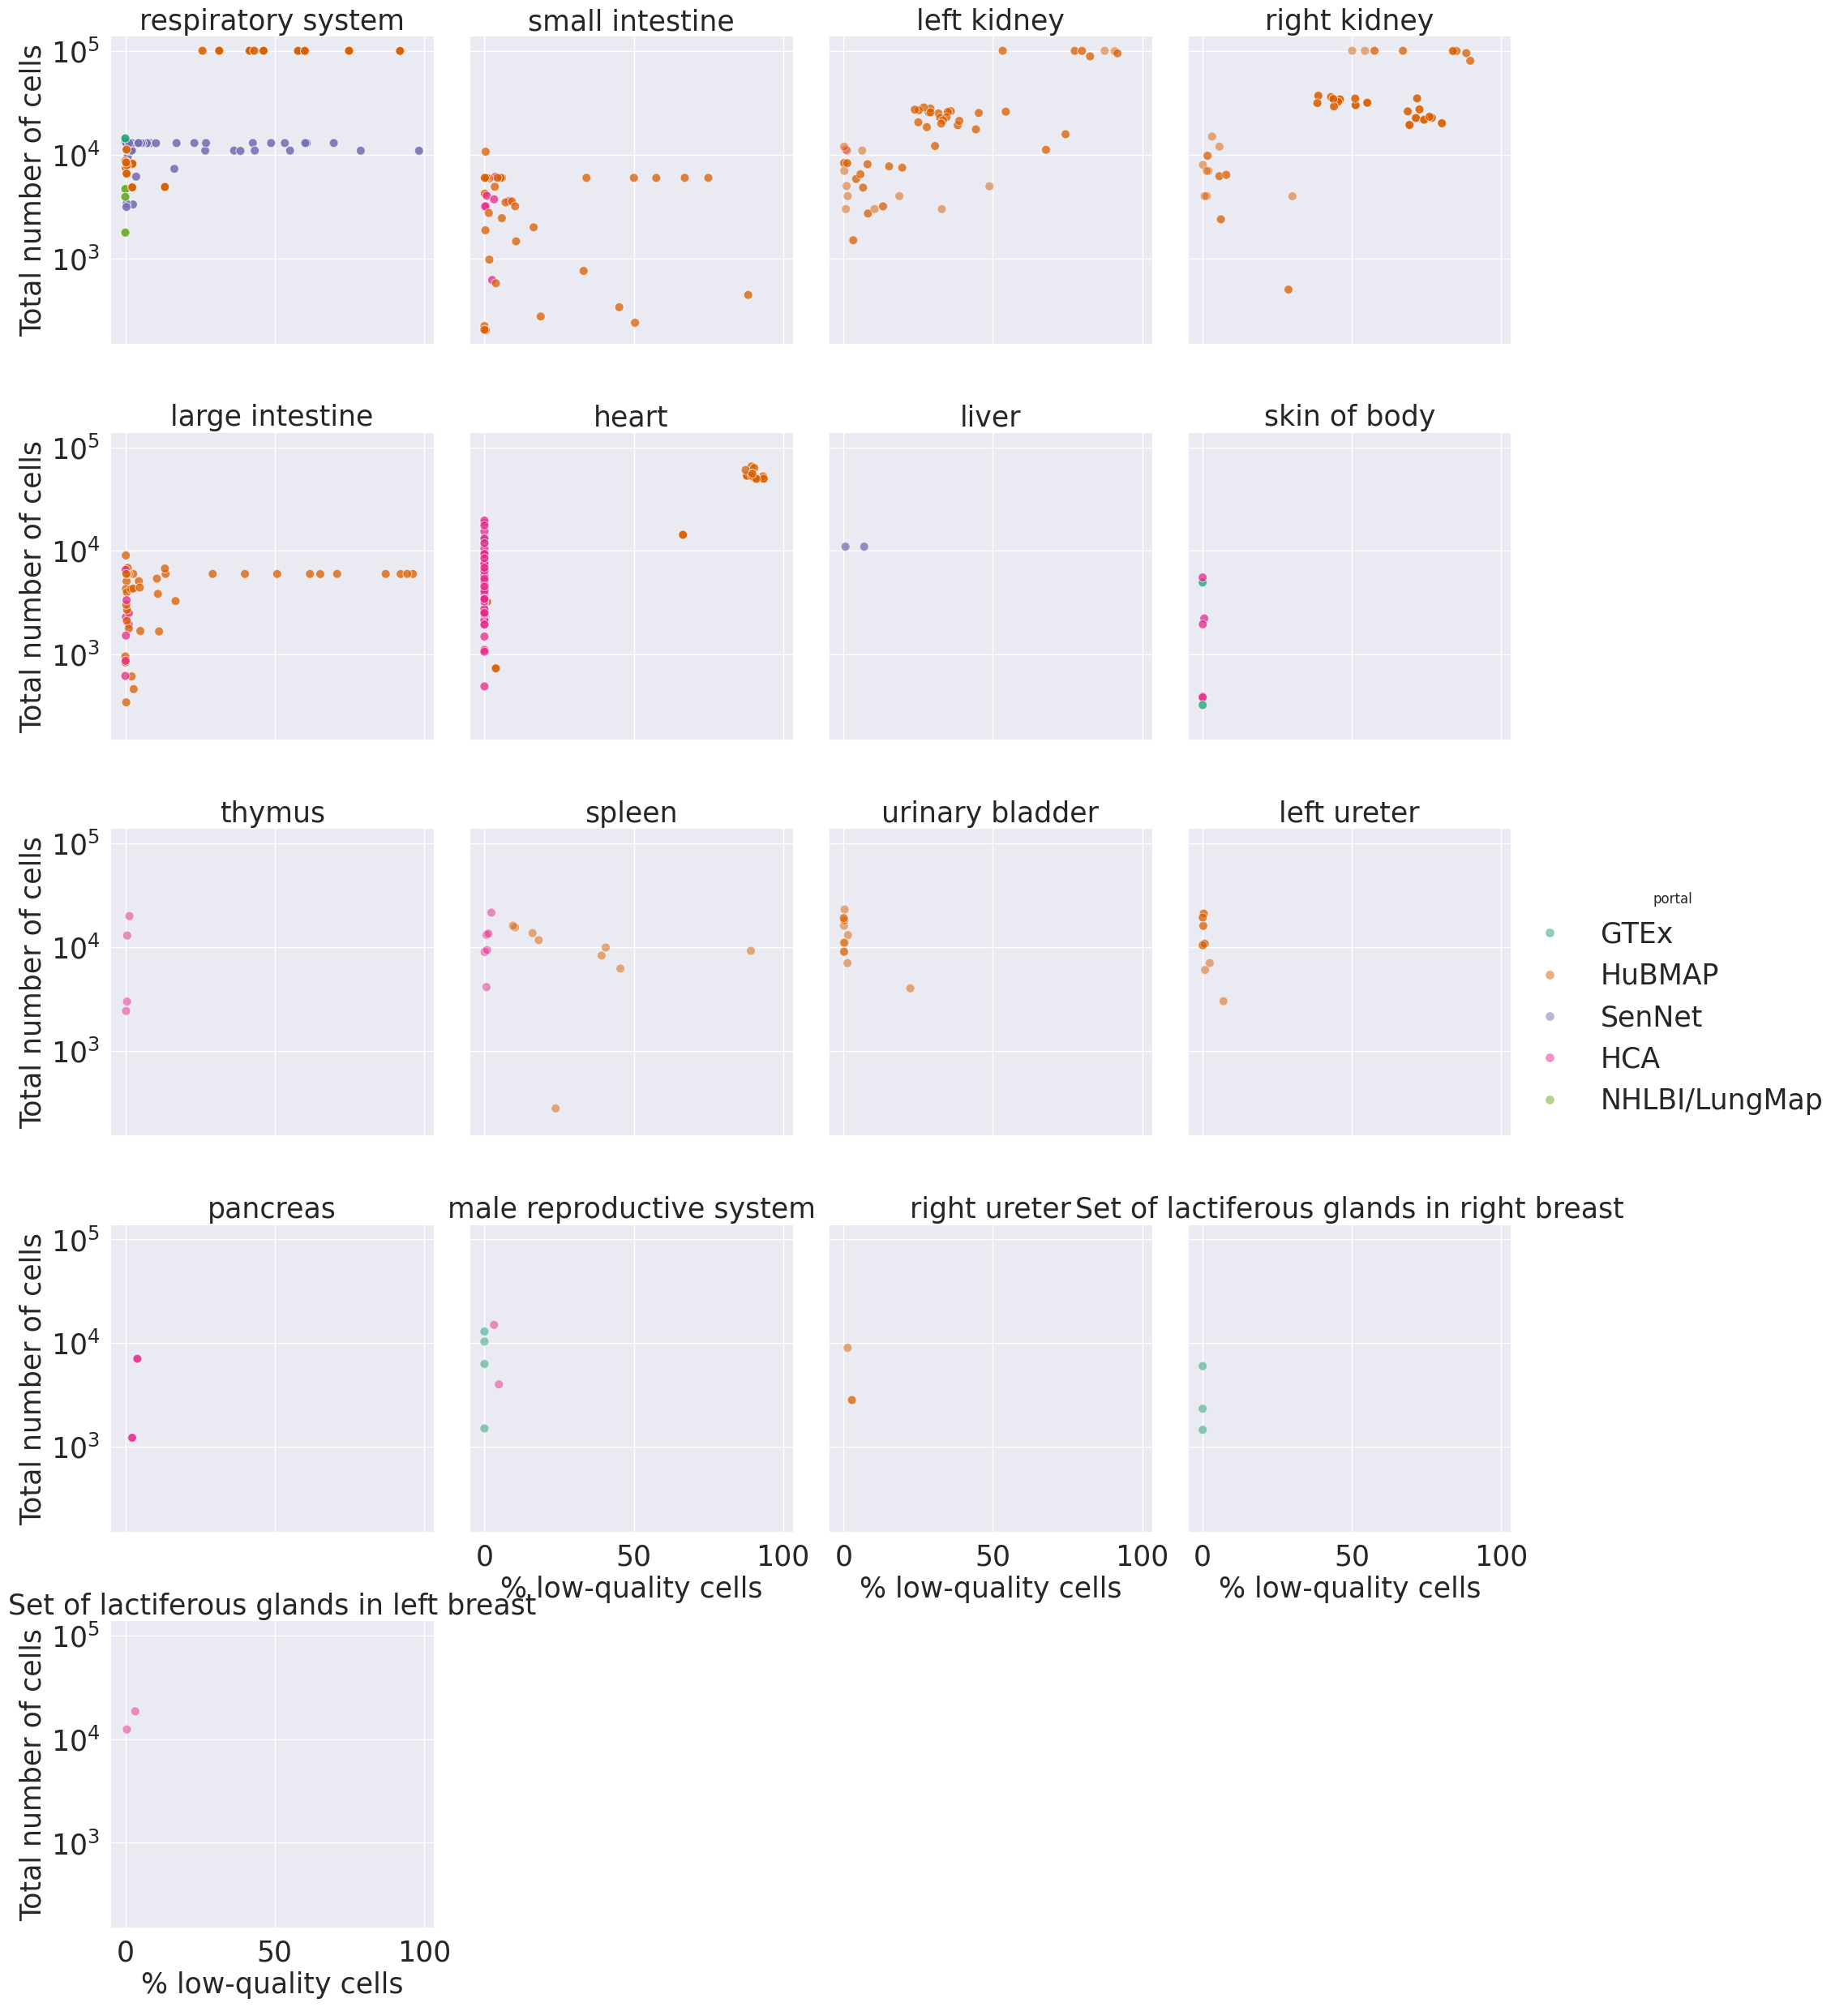

In [24]:
sns.set_theme(
    rc={
        "figure.figsize": (10, 6),
        "font.size": 15,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 25,
        "ytick.labelsize": 25,
        "legend.fontsize": 25,
    },
)

# Facet the scatterplot by organ_name
g = sns.relplot(
    data=df_merged,
    x="percent_low_quality",
    y="total_cells",
    hue="portal",
    col="organ_name",  # facet each organ in its own subplot (column)
    col_wrap=4,  # wrap every 3 plots to a new row
    kind="scatter",
    s=60,
    alpha=.5,
    palette="Dark2"
)

plt.yscale("log")

# Label axes
g.set_axis_labels("% low-quality cells", "Total number of cells")
g.set_titles("{col_name}")

plt.show()